In [1]:
import os
import json
import pandas
import pickle
import sklearn

In [2]:
#### Data path
sourcepath = "data/archive/"
trainpath = "data/processed/"
datalist = os.listdir(sourcepath)
trainlist = os.listdir(trainpath)

## Load data

In [3]:
dataset = []
for i in range(len(datalist)):
    with open(sourcepath + datalist[i]) as rawdata:
        tmpresults = json.load(rawdata)
        dataset.append({"id": tmpresults["_id"], "text": tmpresults["articleContent"]})

df = pandas.DataFrame(dataset)
print(df.head(n=2))

                                  id  \
0  USA_US.CA_06073_20200102.09.02.07   
1  USA_US.CA_06073_20200102.10.10.06   

                                                text  
0  \nInfluenza cases reported last week in San Di...  
1  \nThe beginning of the new year is the perfect...  


In [4]:
trainingset = []

for i in range(len(trainlist)):
    with open(trainpath + trainlist[i]) as traindata:
        tmpresults = json.load(traindata)
        aboutlist = tmpresults["about"]
        for j in range(len(aboutlist)):
            trainingset.append(
                {
                    "id": tmpresults["_id"],
                    "text": tmpresults["articleContent"],
                    "type": aboutlist[j]["@type"],
                    "date": tmpresults["datePublished"],
                }
            )

tf = pandas.DataFrame(trainingset)
print(len(tf))
tf.sort_values("type", ascending=True, inplace=True)
tf.drop_duplicates(keep="first", inplace=True)
tf["category_id"] = tf["type"].factorize()[0]
print(tf.head(n=2))
print(len(tf))

423
                                    id  \
261  USA_US.CA_06073_20200424.12.20.18   
178  USA_US.CA_06073_20200404.17.55.36   

                                                  text                  type  \
261  \nWith positive cases of COVID-19 on the rise,...  AuthorizationRequest   
178  \nA new COVID-19 death was reported in San Die...  AuthorizationRequest   

                          date  category_id  
261  2020-04-24T12:20:18-07:00            0  
178  2020-04-04T17:55:36-07:00            0  
390


## Inspect data

In [44]:
print(
    tf.loc[
        (tf["text"].str.contains("stay home")) & (tf["type"] == "PoliciesAndGuidelines")
    ]
)

                                    id  \
94   USA_US.CA_06073_20200312.16.50.17   
115  USA_US.CA_06073_20200320.20.05.31   
184  USA_US.CA_06073_20200405.16.52.06   
179  USA_US.CA_06073_20200404.17.55.36   
360  USA_US.CA_06073_20200624.17.25.58   
102  USA_US.CA_06073_20200316.17.15.22   
193  USA_US.CA_06073_20200407.16.31.28   
109  USA_US.CA_06073_20200318.17.15.58   
210  USA_US.CA_06073_20200410.17.06.26   
238  USA_US.CA_06073_20200417.18.09.01   
139  USA_US.CA_06073_20200324.18.59.08   
129  USA_US.CA_06073_20200322.19.08.58   
119  USA_US.CA_06073_20200321.19.30.37   
219  USA_US.CA_06073_20200413.18.32.10   
291  USA_US.CA_06073_20200505.18.12.32   
98   USA_US.CA_06073_20200313.18.23.02   

                                                  text                   type  \
94   \nThe County of San Diego today announced that...  PoliciesAndGuidelines   
115  \nCounty officials re-emphasized California Go...  PoliciesAndGuidelines   
184  \nA new COVID-19 death was reported i

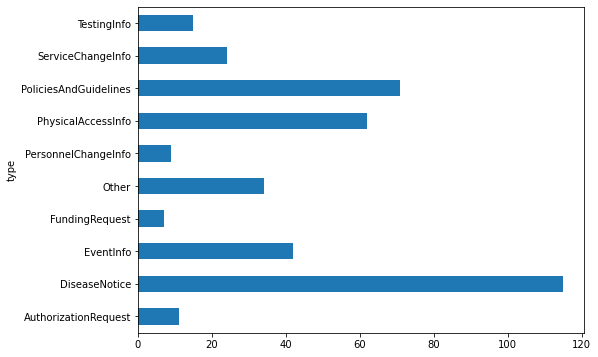

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
tf.groupby("type").text.count().plot.barh(ylim=0)
# plt.show()
plt.savefig("categories.png", dpi=900, bbox_inches="tight")

## create binary training
training tests run on using the entire training dataset as it exists (non-exclusive categories) results in very poor performance. Since the categories are not mutually exclusive, better results can be obtained by creating binary training sets for each of the categories, and then running the algorithm

In [51]:
def create_training_set(alltraindf, eachcategory):
    training_set_pos = alltraindf.loc[alltraindf["type"] == eachcategory].copy()
    training_set_pos_ids = training_set_pos["id"].unique().tolist()
    training_set_neg = alltraindf.loc[
        ~alltraindf["id"].isin(training_set_pos_ids)
    ].copy()
    training_set_pos["target"] = "in category"
    training_set_neg["target"] = "not in category"
    training_set = pandas.concat(
        (training_set_pos, training_set_neg), ignore_index=True
    )
    return training_set

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
)

vectorizer = TfidfVectorizer()

categorylist = tf["type"].unique().tolist()

for eachcategory in categorylist:
    print("analyzing results for: ", eachcategory)
    training_set = create_training_set(tf, eachcategory)
    X = vectorizer.fit_transform(training_set["text"])
    features = vectorizer.get_feature_names()
    #### Split the data into training and test data
    X_train, X_test, y_train, y_test = train_test_split(
        X, training_set.target, test_size=0.2, random_state=0
    )

    #### Classify training text as in category or not in category
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    #### analyze results
    print(confusion_matrix(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    print(pandas.DataFrame(report))
    probs = classifier.predict_proba(X_test)
    probs = probs[:, 1]
    try:
        auc = roc_auc_score(y_test, probs)
        print(auc)
    except:
        print("auc not calculated")
    print("[[true neg     false pos]]")
    print("[[false neg     true pos]]")

analyzing results for:  AuthorizationRequest
[[ 0  2]
 [ 0 68]]
           in category  not in category  accuracy  macro avg  weighted avg
precision          0.0         0.971429  0.971429   0.485714      0.943673
recall             0.0         1.000000  0.971429   0.500000      0.971429
f1-score           0.0         0.985507  0.971429   0.492754      0.957350
support            2.0        68.000000  0.971429  70.000000     70.000000
0.8897058823529411
[[true neg     false pos]]
[[false neg     true pos]]
analyzing results for:  DiseaseNotice


C:\Users\gtsueng\Anaconda3\envs\outbreak\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[20  1]
 [ 0 23]]
           in category  not in category  accuracy  macro avg  weighted avg
precision     1.000000         0.958333  0.977273   0.979167      0.978220
recall        0.952381         1.000000  0.977273   0.976190      0.977273
f1-score      0.975610         0.978723  0.977273   0.977167      0.977237
support      21.000000        23.000000  0.977273  44.000000     44.000000
1.0
[[true neg     false pos]]
[[false neg     true pos]]
analyzing results for:  EventInfo
[[ 5  5]
 [ 0 55]]
           in category  not in category  accuracy  macro avg  weighted avg
precision     1.000000         0.916667  0.923077   0.958333      0.929487
recall        0.500000         1.000000  0.923077   0.750000      0.923077
f1-score      0.666667         0.956522  0.923077   0.811594      0.911929
support      10.000000        55.000000  0.923077  65.000000     65.000000
0.9563636363636363
[[true neg     false pos]]
[[false neg     true pos]]
analyzing results for:  FundingRequest
[[71]]
 

C:\Users\gtsueng\Anaconda3\envs\outbreak\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 4  4]
 [ 2 40]]
           in category  not in category  accuracy  macro avg  weighted avg
precision     0.666667         0.909091      0.88   0.787879      0.870303
recall        0.500000         0.952381      0.88   0.726190      0.880000
f1-score      0.571429         0.930233      0.88   0.750831      0.872824
support       8.000000        42.000000      0.88  50.000000     50.000000
0.9345238095238095
[[true neg     false pos]]
[[false neg     true pos]]
analyzing results for:  PoliciesAndGuidelines
[[ 7  5]
 [ 0 37]]
           in category  not in category  accuracy  macro avg  weighted avg
precision     1.000000         0.880952  0.897959   0.940476      0.910107
recall        0.583333         1.000000  0.897959   0.791667      0.897959
f1-score      0.736842         0.936709  0.897959   0.836775      0.887762
support      12.000000        37.000000  0.897959  49.000000     49.000000
0.9493243243243243
[[true neg     false pos]]
[[false neg     true pos]]
analyzing results fo

C:\Users\gtsueng\Anaconda3\envs\outbreak\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0  3]
 [ 0 64]]
           in category  not in category  accuracy  macro avg  weighted avg
precision          0.0         0.955224  0.955224   0.477612      0.912453
recall             0.0         1.000000  0.955224   0.500000      0.955224
f1-score           0.0         0.977099  0.955224   0.488550      0.933349
support            3.0        64.000000  0.955224  67.000000     67.000000
0.8932291666666667
[[true neg     false pos]]
[[false neg     true pos]]


C:\Users\gtsueng\Anaconda3\envs\outbreak\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm="l2",
    encoding="latin-1",
    ngram_range=(1, 2),
    stop_words="english",
)
features = tfidf.fit_transform(tf.text).toarray()
labels = tf.category_id
features.shape

(365, 6713)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(
    tf["text"], tf["type"], random_state=0
)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [41]:
j = 11
print(tf.iloc[j]["text"])
print(clf.predict(count_vect.transform([tf.iloc[j]["text"]])))


A second San Diego County resident has died from COVID-19, and two infants have been diagnosed with the disease.
Public Health Officer Dr. Wilma Wooten, M.D., M.P.H., reported during a news conference Tuesday that the 76-year-old man had significant health issues. Wooten also noted the first two San Diego County cases of coronavirus disease in infants, a 6-week-old boy and a 4-month-old girl. Both are currently isolated in their homes.
Cases are increasing daily and Wooten doesn’t expect a downturn anytime soon.
“Things are likely to get worse before they get better. We do not believe that the local wave of COVID-19 cases has yet crested,” said Wooten. “It’s incumbent upon on all of us to do our part to flatten the curve.”
Cases Rise to 242
Through 5 p.m. Tuesday, the County total number of confirmed COVID-19 cases increased to 242, 12 more than Monday. Two San Diego County residents have died.
Of the total, 226 were San Diego County residents and 16 were non-residents.
Of the 242 cas

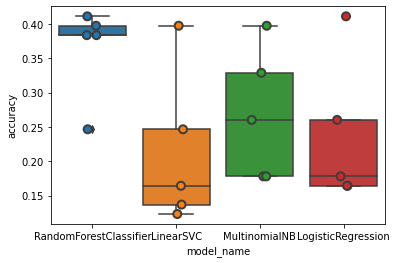

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pandas.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pandas.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

import seaborn as sns

sns.boxplot(x="model_name", y="accuracy", data=cv_df)
sns.stripplot(
    x="model_name",
    y="accuracy",
    data=cv_df,
    size=8,
    jitter=True,
    edgecolor="gray",
    linewidth=2,
)
plt.show()

In [33]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

model = LinearSVC()
import seaborn as sns

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, tf.index, test_size=0.25, random_state=0
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
"""
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')#, xticklabels=tf.type, yticklabels=tf.type)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
"""

[[7 0 0 0 2 3 0 1]
 [1 2 2 0 0 2 0 0]
 [1 2 3 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [3 0 0 0 3 1 0 0]
 [5 0 0 0 1 0 0 0]
 [0 0 1 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]]


"\nfig, ax = plt.subplots(figsize=(10,10))\nsns.heatmap(conf_mat, annot=True, fmt='d')#, xticklabels=tf.type, yticklabels=tf.type)\nplt.ylabel('Actual')\nplt.xlabel('Predicted')\nplt.show()\n"

In [ ]:
# importing necessary libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


# X -> features, y -> label
X = tf.data
y = tf.cate

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

dtree_model = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)